### Binary classification with Non-Deep learning algorithms: Naive Bayes and SVM
We will use Naive Bayes and Support Vector machine.


In [2]:
!pip install --upgrade numpy
!pip install --upgrade pandas
#!pip install pyspark==2.4.5
!pip install -U scikit-learn

     |████████████████████████████████| 14.5MB 5.8MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
     |████████████████████████████████| 10.5MB 8.9MB/s eta 0:00:01
ERROR: ibm-watson-machine-learning 1.0.10 has requirement pandas<=0.25.3, but you'll have pandas 1.1.2 which is incompatible.
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
     |████████████████████████████████| 6.8MB 8.8MB/s eta 0:00:01
     |████████████████████████████████| 307kB 23.8MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement scikit-learn==0.20.3, but you'll have scikit-learn 0.23.2 which is incompatible.
  Found existing installation: scikit-learn 0

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from time import time
import logging
import numpy as np
import pandas as pd
import string
import re
from datetime import datetime
from packaging import version

from ibm_botocore.client import Config
import ibm_boto3

from sklearn.model_selection import train_test_split
#pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : 2a7d3326dee660824a8433ffd01065f8ac37f7d6
python           : 3.6.9.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.15.0-112-generic
Version          : #113-Ubuntu SMP Thu Jul 9 23:41:39 UTC 2020
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.2
numpy            : 1.19.2
pytz             : 2018.9
dateutil         : 2.7.5
pip              : 19.1.1
setuptools       : 40.8.0
Cython           : 0.29.5
pytest           : 4.2.1
hypothesis       : None
sphinx           : 1.8.4
blosc            : None
feather          : None
xlsxwriter       : 1.1.2
lxml.etree       : 4.3.1
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.7.6.1 (dt dec pq3 ext lo64)
jinja2           : 2.10
IPython          : 7.2.0
pandas_datareader: None
bs4              : 4.7.1


In [4]:
#Get our data from IBM Cloud

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_news = {
    'IAM_SERVICE_ID': 'iam-ServiceId-32e8ee67-397c-4ff1-b69b-543172331f43',
    'IBM_API_KEY_ID': 'Rx4FR4JSAueCnnIsoevsgYgOsuh8LCXtbkFpFpC0EmVU',
    #'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'ENDPOINT':'https://s3-api.us-geo.objectstorage.softlayer.net',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'advanceddatasciencecapstone-donotdelete-pr-tqabpnbxebk8rm',
    'FILE': 'dfTrueFalseNews.pkl'
}

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

def upload_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.upload_file(Filename=local_file_name, Bucket=credentials['BUCKET'],Key=key)
    except Exception as e:
        print(Exception, e)
    else:
        print(' File Uploaded')
        
dfNews = download_file_cos(credentials_news, "dfTrueFalseNews.pkl", "dfTrueFalseNews.pkl")
dfTrueFalseNews_tokenized  = download_file_cos(credentials_news,'dfTrueFalseNews_tokenized.pkl','dfTrueFalseNews_tokenized.pkl')

File Downloaded
File Downloaded


In [5]:
dfNewsTemp = pd.read_pickle('dfTrueFalseNews.pkl')
dfTrueFalseNews_tokenized = pd.read_pickle('dfTrueFalseNews_tokenized.pkl')
#dfNews['truthvalue'] = pd.Categorical(dfNews['truthvalue'])

x = dfNewsTemp['text'].values

y = dfNewsTemp['truthvalue'].values

print (dfNewsTemp.shape, dfNewsTemp.columns, '\n', dfNewsTemp.dtypes, type(x), type(y))


(1126, 3) Index(['text', 'source', 'truthvalue'], dtype='object') 
 text          object
source        object
truthvalue    object
dtype: object <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [6]:
dfNewsTemp.dtypes



text          object
source        object
truthvalue    object
dtype: object

### Prepare the Text for Word2Vec
1. Change all the text to lower case
2. Split stories into sentences.
3. Word Tokenization and removing non-alpha text.

In [7]:
!pip install gensim

     |████████████████████████████████| 24.2MB 14.4MB/s eta 0:00:01    |██████████████▏                 | 10.7MB 7.1MB/s eta 0:00:02
     |████████████████████████████████| 112kB 32.8MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/17/49/ea/74939572d8d071ff3c63a98e3e8dadef1117cc93c33efaa504
Successfully built smart-open


In [8]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import wordnet as wn
from collections import defaultdict
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# reproduce the same result every time the script is run.
np.random.seed(500)

[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
import gensim

ModuleNotFoundError: No module named 'Word2Vec'

## Analyze average number of sentences in each story and average words in sentence

In [65]:
from statistics import mean
sentencecount =[]
sentencewordcount= []
for s in dfNewsTemp['text']:
    a = sent_tokenize(s)
    sentencecount.append(len(a))
    swc = [len(word_tokenize(i)) for i in a]
    sentencewordcount.extend(swc)

print ("Average sentence count in stories: {} Average sentence length in tokens:{} Max sentence length: {}".format(mean(sentencecount), mean(sentencewordcount), max(sentencewordcount)))



Average sentence count in stories: 16.350799289520427 Average sentence length in tokens:23.496822551735377 Max sentence length: 267


In [15]:
#dfNewsTemp['text'].values[-1]
dfNewsTemp['text_final'].values[-1]

[['shocking',
  'images',
  'out',
  'of',
  'classroom',
  'in',
  'jacksonville',
  'florida',
  'illustrate',
  'how',
  'year',
  'olds',
  'in',
  'th',
  'grade',
  'are',
  'being',
  'taught',
  'how',
  'to',
  'use',
  'strap',
  'on',
  'dildos',
  'amidst',
  'debate',
  'about',
  'sexual',
  'content',
  'finding',
  'its',
  'way',
  'into',
  'other',
  'common',
  'core',
  'subjects',
  'material',
  'which',
  'has',
  'been',
  'attacked',
  'by',
  'some',
  'as',
  'pornographic'],
 ['the',
  'pictures',
  'were',
  'taken',
  'by',
  'student',
  'with',
  'cellphone',
  'camera'],
 ['they',
  'show',
  'teacher',
  'demonstrating',
  'how',
  'to',
  'use',
  'strap',
  'on',
  'sex',
  'toy',
  'in',
  'number',
  'of',
  'different',
  'positions'],
 ['in',
  'one',
  'image',
  'the',
  'teacher',
  'even',
  'shows',
  'how',
  'to',
  'insert',
  'the',
  'strap',
  'on',
  'while',
  'her',
  'buttocks',
  'are',
  'in',
  'the',
  'air',
  'and',
  'her',

In [12]:
# Step 0: Change all the text to lower case.
dfNewsTemp['text'] = [entry.lower() for entry in dfNewsTemp['text']]

In [13]:
# Step 1: Split text into sentences using NLTK
#dfNewsTemp['text'] = will be a list of sentences.

dfNewsTemp['text'] = [sent_tokenize(entry) for entry in dfNewsTemp['text']]

In [14]:
# Step 2: Tokenization : Each entry will be broken into set of words
# The Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank. 
# This is the method that is invoked by word_tokenize(). It assumes that the text has already been segmented into sentences, e.g. using sent_tokenize().
import gensim
from gensim.utils import simple_preprocess
tokenlist =[]
for index, story in enumerate(dfNewsTemp['text']):
    print (index, end= ', ')
    tokens = [simple_preprocess(sentence) for sentence in story]  #Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
    tokenlist.append(tokens)
dfNewsTemp['text_final'] = tokenlist

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [16]:
# This took a while, so let's save the result.
dfNewsTemp.to_pickle('dfTrueFalseNews_tokenized_w2v.pkl', protocol=4 )

# save to our cloud storage 
upload_file_cos(credentials_news,'dfTrueFalseNews_tokenized_w2v.pkl','dfTrueFalseNews_tokenized_w2v.pkl')

 File Uploaded


In [53]:
# Step 3: Put all sentences into a single array to train word2vec.
sentencelist = []
for tokens in tokenlist:
    for sentence in tokens:
        sentencelist.append(sentence)
print (len(sentencelist), sentencelist[0], sentencelist[-1])

18003 ['google', 'computer', 'victorious', 'over', 'the', 'world', 'go', 'champion', 'on', 'saturday', 'google', 'computer', 'clocked', 'its', 'third', 'consecutive', 'victory', 'over', 'lee', 'se', 'dol', 'the', 'long', 'reigning', 'global', 'champion', 'of', 'the', 'world', 'most', 'complex', 'board', 'game'] ['infowars', 'com', 'videos']


In [54]:
# Step 4: train word2vec model
from gensim.models import Word2Vec
model = Word2Vec(sentencelist, size=100, window=5, workers=1, min_count=1)
# summarize vocabulary size in model
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))
 
# save model in ASCII (word2vec) format
#filename = 'embedding_word2vec.txt'
#model.wv.save_word2vec_format(filename, binary=False)
#upload_file_cos(credentials_news,'embedding_word2vec.txt','embedding_word2vec.txt')
model.save("embedding_word2vec.model")
upload_file_cos(credentials_news, "embedding_word2vec.model", "embedding_word2vec.model")

Vocabulary size: 21671
 File Uploaded
 File Uploaded


In [55]:
#download_file_cos(credentials_news,'embedding_word2vec.txt','embedding_word2vec.txt')
#model_vectors =  gensim.models.KeyedVectors.load_word2vec_format('embedding_word2vec.txt', binary=False)
download_file_cos(credentials_news,"embedding_word2vec.model","embedding_word2vec.model")
model = Word2Vec.load("embedding_word2vec.model")
model_vectors = model.wv

File Downloaded


In [121]:
from tensorflow.keras.preprocessing.text import Tokenizer

/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/frame

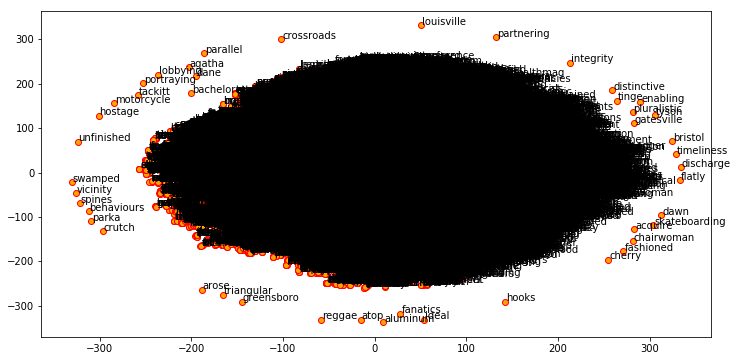

In [76]:
# visualize embeddings
from sklearn.manifold import TSNE

words = model.wv.index2word
wvs = model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
# Step 3,4,5: Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [ ]:
# Initializing WordNetLemmatizer()
word_Lemmatized = WordNetLemmatizer()
#dfNewsTemp.loc['text_final'].astype('object')
col = []
for index,entry in enumerate(dfNewsTemp['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    #word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        #if word not in stopwords.words('english') and word.isalpha():
        if word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    
    #dfNewsTemp.loc[index,'text_final'] = " ".join(Final_words)
    #dfNewsTemp.loc[index,'text_final'] = Final_words
    col.append(" ".join(Final_words))
dfNewsTemp['text_final'] = col


In [ ]:
#dfNewsTemp['text_final'] = col
#col[-1]

In [78]:
dfTrueFalseNews_tokenized  = download_file_cos(credentials_news,'dfTrueFalseNews_tokenized.pkl', 'dfTrueFalseNews_tokenized.pkl')
!ls -al

File Downloaded
total 65876
drwxr-x--- 3 dsxuser dsxuser     4096 Sep 17 19:26 .
drwx------ 1 dsxuser dsxuser     4096 Sep 17 14:03 ..
-rw-r----- 1 dsxuser dsxuser  2228457 Sep 17 14:03 dfTrueFalseNews.pkl
-rw-r----- 1 dsxuser dsxuser  5159678 Sep 17 19:26 dfTrueFalseNews_tokenized.pkl
-rw-r----- 1 dsxuser dsxuser  5112781 Sep 17 14:07 dfTrueFalseNews_tokenized_w2v.pkl
-rw-r----- 1 dsxuser dsxuser 27357210 Sep 17 16:47 embedding_word2vec.model
-rw-r----- 1 dsxuser dsxuser 27555568 Sep 17 16:49 embedding_word2vec.txt
-rw-r----- 1 dsxuser dsxuser     9204 Sep 17 19:26 model_evaluation_utils.py
drwxr-x--- 2 dsxuser dsxuser     4096 Sep 17 19:26 __pycache__


In [79]:
dfTrueFalseNews_tokenized = pd.read_pickle('dfTrueFalseNews_tokenized.pkl')
dfTrueFalseNews_tokenized.head()

,text,source,truthvalue,text_final
tech003legit,"[a, google, computer, victorious, over, the, w...",MihalceaNewsLegit,1,a google computer victorious over the world ch...
polit11legit,"[white, house, keeps, up, sanctuary, cities, p...",MihalceaNewsLegit,1,white house keep up sanctuary city pressure wi...
biz40legit,"[why, silicon, valley, is, n't, fighting, to, ...",MihalceaNewsLegit,1,why silicon valley be fight to save the intern...
edu10legit,"[protesters, disrupt, devos, school, visit, pr...",MihalceaNewsLegit,1,protester disrupt devos school visit protester...
tech038legit,"[solar-powered, 'skin, ', could, make, prosthe...",MihalceaNewsLegit,1,could make prosthetics more real many people t...


In [80]:
from sklearn import model_selection
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dfTrueFalseNews_tokenized['text_final'],dfTrueFalseNews_tokenized['truthvalue'],test_size=0.1)
#print(dfTrueFalseNews_tokenized.shape, (dfTrueFalseNews_tokenized['text_final'].shape), (dfTrueFalseNews_tokenized['truthvalue'].shape))
#dfTrueFalseNews_tokenized['text_final'][0]

In [81]:
#corpus = [" ".join(i) for i in dfTrueFalseNews_tokenized['text_final']]
#corpus[1:3]
dfTrueFalseNews_tokenized.head()

#dfTrueFalseNews_tokenized.dtypes
#import sklearn
#sklearn.show_versions()

,text,source,truthvalue,text_final
tech003legit,"[a, google, computer, victorious, over, the, w...",MihalceaNewsLegit,1,a google computer victorious over the world ch...
polit11legit,"[white, house, keeps, up, sanctuary, cities, p...",MihalceaNewsLegit,1,white house keep up sanctuary city pressure wi...
biz40legit,"[why, silicon, valley, is, n't, fighting, to, ...",MihalceaNewsLegit,1,why silicon valley be fight to save the intern...
edu10legit,"[protesters, disrupt, devos, school, visit, pr...",MihalceaNewsLegit,1,protester disrupt devos school visit protester...
tech038legit,"[solar-powered, 'skin, ', could, make, prosthe...",MihalceaNewsLegit,1,could make prosthetics more real many people t...


### Use Naive Bayes Classifier with different Vectorization settings
 continuing the initial work from https://github.com/adamx97/Data-Science-Advanced-Capstone/blob/master/NaiveBayesAndSVM.ipynb

In [77]:
# some open source utilities to evaluate a model.
# you can see them at: https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch05_Building_Tuning_and_Deploying_Models/model_evaluation_utils.py
download_file_cos(credentials_news,'model_evaluation_utils.py', 'model_evaluation_utils.py')
import importlib
#importlib.reload(model_evaluation_utils)
import model_evaluation_utils as meu

File Downloaded


In [104]:
# using standard english stop words improves performance by 6%

from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(stop_words='english')
Tfidf_vect.fit(dfTrueFalseNews_tokenized['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Train_y_int = Train_Y.astype('int')
Test_y_int = Test_Y.astype('int')
Naive.fit(Train_X_Tfidf,Train_y_int)# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_y_int)* 100)
print("Naive model params: {}".format(Naive.get_params()))
meu.display_model_performance_metrics(true_labels=Test_y_int.tolist(), predicted_labels=predictions_NB.tolist())

Naive Bayes Accuracy Score ->  40.707964601769916
Naive model params: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Model Performance metrics:
------------------------------
Accuracy: 0.4071
Precision: 0.4065
Recall: 0.4071
F1 Score: 0.3975

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.40      0.29      0.34        59
           0       0.41      0.54      0.46        54

    accuracy                           0.41       113
   macro avg       0.41      0.41      0.40       113
weighted avg       0.41      0.41      0.40       113


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   1   0
Actual: 1         17  42
        0         25  29


In [110]:
# unigrams and bigrams and ngrams oh, my!
#Tfidf_vect = TfidfVectorizer(max_features=26000) # accuracy 36%
Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))# Accuracy 40.71%
#Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(2,2)) # Accuracy 30.08%
#Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,3)) # Accuracy 38.93%
#Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,4)) # Accuracy 38.94%
Tfidf_vect.fit(dfTrueFalseNews_tokenized['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Train_y_int = Train_Y.astype('int')
Test_y_int = Test_Y.astype('int')
Naive.fit(Train_X_Tfidf,Train_y_int)# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_y_int)* 100)
print("Naive model params: {}".format(Naive.get_params()))
meu.display_model_performance_metrics(true_labels=Test_y_int.tolist(), predicted_labels=predictions_NB.tolist())

Naive Bayes Accuracy Score ->  40.707964601769916
Naive model params: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Model Performance metrics:
------------------------------
Accuracy: 0.4071
Precision: 0.4052
Recall: 0.4071
F1 Score: 0.3945

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.40      0.27      0.32        59
           0       0.41      0.56      0.47        54

    accuracy                           0.41       113
   macro avg       0.41      0.41      0.40       113
weighted avg       0.41      0.41      0.39       113


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   1   0
Actual: 1         16  43
        0         24  30


### Discussion
This is a Naive Bayes model using a Bag of Words TF-IDF encoding. 

The result of 34% accuracy is not very good.  

## Use Support Vector Machine with different Vectorization
continuing the initial work from https://github.com/adamx97/Data-Science-Advanced-Capstone/blob/master/NaiveBayesAndSVM.ipynb

In [120]:
from sklearn import svm
#Tfidf_vect = TfidfVectorizer(max_features=26000) # Accuracy 59.29%
Tfidf_vect = TfidfVectorizer() # Accuracy 59.29%  (this is the same as above, because the vocab size is less than 26,000, so the vectorization is the same.)
#Tfidf_vect = TfidfVectorizer(stop_words='english') # Accuracy 46.9%
#Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,1))# Accuracy 46.9%
#Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))# Accuracy 46.9%
#Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(2,2)) # Accuracy 33.62%
#Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,3)) # Accuracy 45.13%
#Tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,4)) # Accuracy 45.13%
Tfidf_vect.fit(dfTrueFalseNews_tokenized['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.5, kernel='sigmoid', degree=3, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_y_int)# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> {}".format(accuracy_score(predictions_SVM, Test_y_int)*100))
print("SVM model params: {}".format(Naive.get_params()))
meu.display_model_performance_metrics(true_labels=Test_Y.tolist(), predicted_labels=predictions_SVM.tolist())

SVM Accuracy Score -> 59.29203539823009
SVM model params: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Model Performance metrics:
------------------------------
Accuracy: 0.5929
Precision: 0.6035
Recall: 0.5929
F1 Score: 0.5889

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.64      0.49      0.56        59
           0       0.56      0.70      0.62        54

    accuracy                           0.59       113
   macro avg       0.60      0.60      0.59       113
weighted avg       0.60      0.59      0.59       113


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   1   0
Actual: 1         29  30
        0         16  38


### Discussion

This is a Support Vector Machine using the same Bag of Words TF-IDF encoding as above and does surprisingly better, with a 60% accuracy rate that rivals others results.



### Split the data

In [ ]:
# use the dataframe to write a parquet file
dfNewsTemp.to_parquet('dfTrueFalseNews_tokenized.parquet')
dfNews = spark.read.parquet('dfTrueFalseNews_tokenized.parquet')
dfNews.createOrReplaceTempView('dfNews')

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dfNewsTemp['text_final'],Corpus['label'],test_size=0.1)

In [ ]:
splits = dfNews.randomSplit([0.9, 0.1])
df_train = splits[0]
df_test = splits[1]

